In [1]:
import os
import glob
import cv2
import numpy as np
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [2]:
def caliberate_camera(lst_img_path, nx, ny):
    lst_objpoints = []
    lst_imgpoints = []
    objpoints = np.zeros((nx*ny, 3), dtype=np.float32)
    objpoints[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)
    for img_path in lst_img_path:
        img = mpimg.imread(img_path)
        img_size = (img.shape[1], img.shape[0])
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
        if ret:
            lst_objpoints.append(objpoints)
            lst_imgpoints.append(corners)
    ret, mat, dist, rvecs, tvecs = cv2.calibrateCamera(lst_objpoints, lst_imgpoints, img_size, None, None)
    return ret, mat, dist

In [3]:
lst_img_path = glob.glob("camera_cal/calibration*.jpg")
nx, ny = 9, 6
ret, mat, dist = caliberate_camera(lst_img_path, nx, ny)

def undistort(img_dist):
    return cv2.undistort(img_dist, mat, dist, None, mat)

In [4]:
def test_calibration(img_dist):
    img_udist = undistort(img_dist)

    fig = plt.figure(figsize=(12, 24))

    fig.add_subplot(1, 2, 1)
    plt.imshow(img_dist)
    plt.title("Distorted")

    fig.add_subplot(1, 2, 2)
    plt.imshow(img_udist)
    plt.title("Un Distorted")

    plt.show();

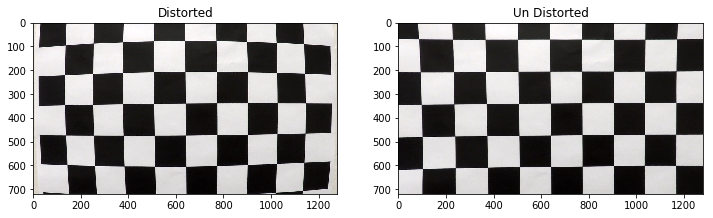

In [5]:
img = mpimg.imread("camera_cal/calibration1.jpg")
test_calibration(img)

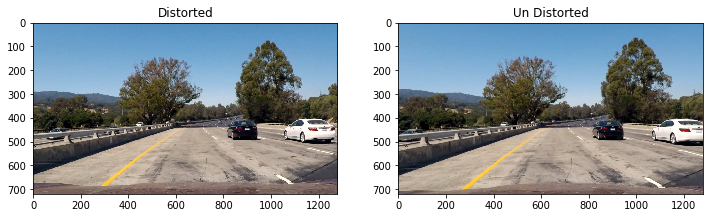

In [6]:
img = mpimg.imread("test_images/test1.jpg")
test_calibration(img)

In [7]:
def abs_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    dx = 1 if orient=='x' else 0
    dy = 1 if orient=='y' else 0
    grad = cv2.Sobel(gray, cv2.CV_64F, dx, dy, None, ksize=sobel_kernel)
    scaled = np.uint8(255. * grad / grad.max())
    binary = np.zeros_like(scaled)
    binary[(scaled >= thresh[0]) & (scaled <= thresh[1])] = 1
    return binary

In [8]:
def mag_thresh(img, sobel_kernel=3, thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gradx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, None, ksize=sobel_kernel)
    grady = cv2.Sobel(gray, cv2.CV_64F, 0, 1, None, ksize=sobel_kernel)
    mag = np.sqrt(gradx**2 + grady**2)
    scaled = np.uint8(255. * mag / mag.max())
    binary = np.zeros_like(scaled)
    binary[(scaled >= thresh[0]) & (scaled <= thresh[1])] = 1
    return binary

In [9]:
def dir_thresh(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gradx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, None, ksize=sobel_kernel)
    grady = cv2.Sobel(gray, cv2.CV_64F, 0, 1, None, ksize=sobel_kernel)
    abs_gradx = np.abs(gradx)
    abs_grady = np.abs(grady)
    dir = np.arctan2(abs_grady, abs_gradx)
    binary = np.zeros_like(dir, dtype=int)
    binary[(dir >= thresh[0]) & (dir <= thresh[1])] = 1
    return binary

In [10]:
def hls_thresh(img, channel='S', thresh=(0, 255)):
    if channel == 'H':
        ichannel = 0
    elif channel == 'L':
        ichannel = 1
    else:
        ichannel = 2
    img_hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    img_mono = img_hls[:, :, ichannel]
    scaled = np.uint8(255. * img_mono / img_mono.max())
    binary = np.zeros_like(scaled)
    binary[(scaled >= thresh[0]) & (scaled <= thresh[1])] = 1
    return binary

In [11]:
def gray_thresh(img, thresh=(0, 255)):
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    scaled = np.uint8(255. * img_gray / img_gray.max())
    binary = np.zeros_like(scaled)
    binary[(scaled >= thresh[0]) & (scaled <= thresh[1])] = 1
    return binary

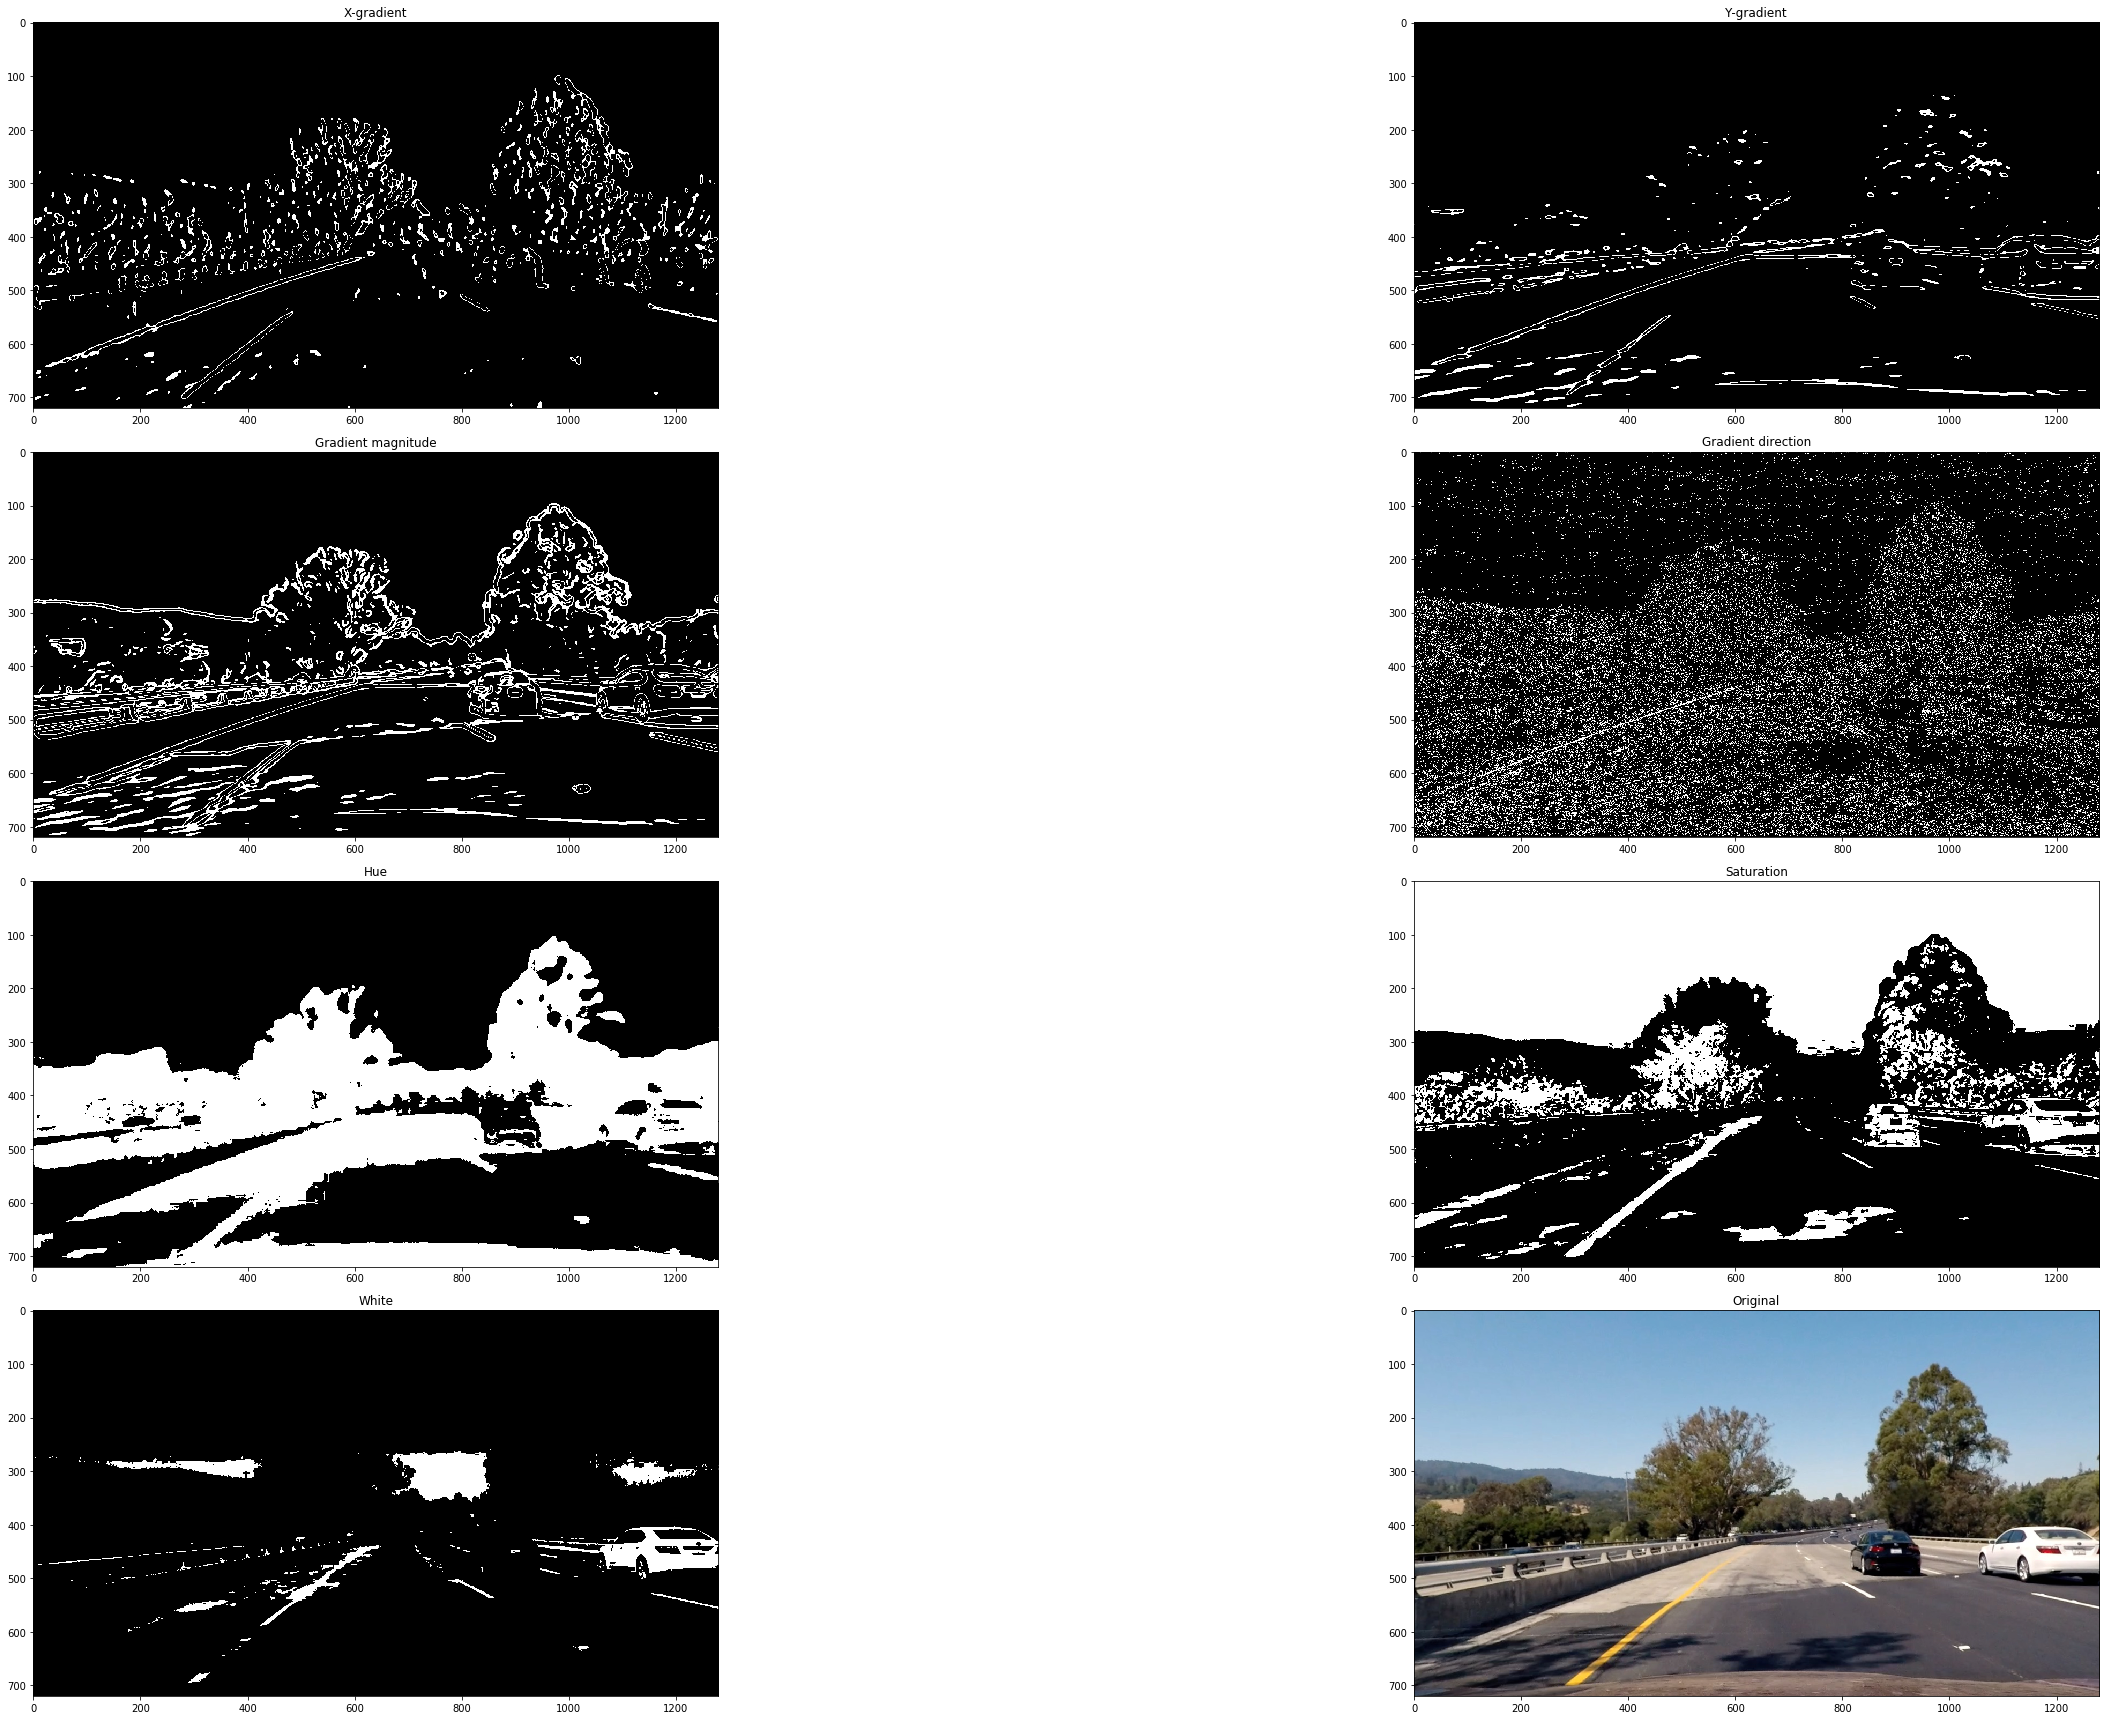

In [12]:
img_dist = mpimg.imread("examples/test4.jpg")
img = undistort(img_dist)

fig = plt.figure(figsize=(48, 24))

fig.add_subplot(4, 2, 1)
plt.imshow(abs_thresh(img, sobel_kernel=31, orient='x', thresh=(20, 40)), cmap='gray')
plt.title('X-gradient')

fig.add_subplot(4, 2, 2)
plt.imshow(abs_thresh(img, sobel_kernel=31, orient='y', thresh=(40, 80)), cmap='gray')
plt.title('Y-gradient')

fig.add_subplot(4, 2, 3)
plt.imshow(mag_thresh(img, sobel_kernel=31, thresh=(40, 80)), cmap='gray')
plt.title('Gradient magnitude')

fig.add_subplot(4, 2, 4)
plt.imshow(dir_thresh(img, sobel_kernel=1, thresh=(4*np.pi/12, 5*np.pi/12)), cmap='gray')
plt.title('Gradient direction')

fig.add_subplot(4, 2, 5)
plt.imshow(hls_thresh(img, channel='H', thresh=(0, 60)), cmap='gray')
plt.title('Hue')

fig.add_subplot(4, 2, 6)
plt.imshow(~hls_thresh(img, channel='S', thresh=(0, 80)), cmap='gray')
plt.title('Saturation')

fig.add_subplot(4, 2, 7)
plt.imshow(gray_thresh(img, thresh=(200, 255)), cmap='gray')
plt.title('White')

fig.add_subplot(4, 2, 8)
plt.imshow(img)
plt.title('Original')

plt.tight_layout()

plt.show()

In [13]:
def binary_grad_filter(img):
    binary_gradx = abs_thresh(img, sobel_kernel=31, orient='x', thresh=(20, 40))
    binary_grady = abs_thresh(img, sobel_kernel=31, orient='y', thresh=(40, 80))
    binary_mag = mag_thresh(img, sobel_kernel=31, thresh=(40, 80))
    binary_dir = dir_thresh(img, sobel_kernel=1, thresh=(5*np.pi/12, 5*np.pi/12))
    binary_grad_filtered = binary_mag #(binary_grady | binary_gradx)# & binary_dir
    return binary_gradx

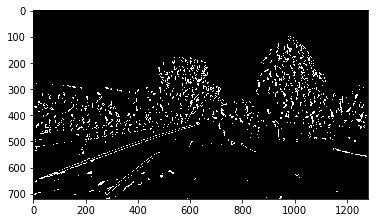

In [14]:
img_dist = mpimg.imread("examples/test4.jpg")
img = undistort(img_dist)

binary_grad_filtered = binary_grad_filter(img)
img_grad_filtered = np.uint8(255 * binary_grad_filtered)
plt.imshow(img_grad_filtered, cmap='gray');

In [15]:
def binary_channel_filter(img):
    binary_H = hls_thresh(img, channel='H', thresh=(25, 30))
    binary_S = ~hls_thresh(img, channel='S', thresh=(0, 25))
    binary_gray = gray_thresh(img,  thresh=(200, 255))
    binary_channel_filtered = ((binary_H & binary_S) | binary_gray)
    return binary_channel_filtered

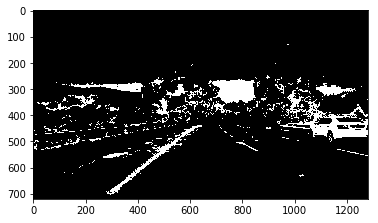

In [16]:
img_dist = mpimg.imread("examples/test4.jpg")
img = undistort(img_dist)

binary_channel_filtered = binary_channel_filter(img)
img_binary_channel_filtered = np.uint8(255 * binary_channel_filtered)
plt.imshow(img_binary_channel_filtered, cmap='gray');

In [17]:
def filter(img):
    img_binary_grad_filtered = binary_grad_filter(img)
    img_binary_channel_filtered = binary_channel_filter(img)
    mask = np.ones_like(img_binary_channel_filtered)
    mask[600:720,550:850] = 0
    img_binary_filtered = np.uint8(255 * ((img_binary_grad_filtered | img_binary_channel_filtered) & mask))
    return img_binary_filtered

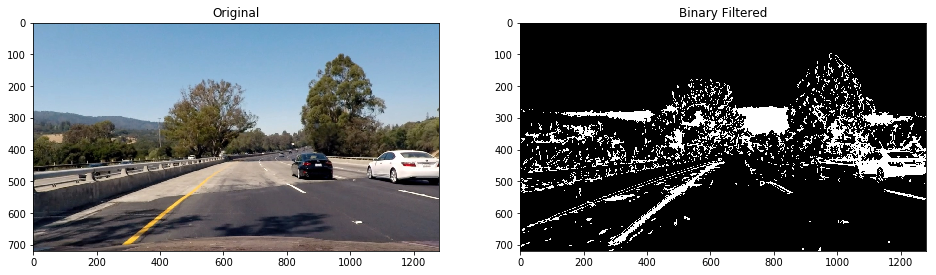

In [18]:
img_dist = mpimg.imread("examples/test4.jpg")
img = undistort(img_dist)
img_binary_filtered = filter(img)

fig = plt.figure(figsize=(16, 32))

fig.add_subplot(1, 2, 1)
plt.imshow(img)
plt.title('Original')

fig.add_subplot(1, 2, 2)
plt.imshow(img_binary_filtered, cmap='gray')
plt.title('Binary Filtered')

plt.show()

In [19]:
src = np.array([(100,720), (580,450), (700,450), (1180,720)], np.float32)
dst = np.array([(80,720), (80,0), (1200,0), (1200,720)], np.float32)
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

def warp(img):
    return cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]), cv2.INTER_LINEAR)

def unwarp(img_warped):
    return cv2.warpPerspective(img_warped, Minv, (img.shape[1], img.shape[0]))

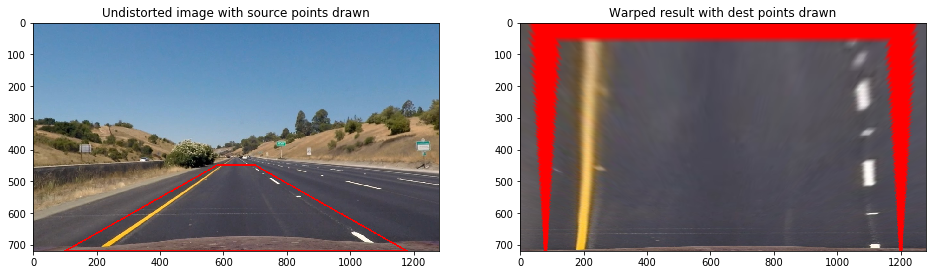

In [20]:
img_dist = mpimg.imread("test_images/straight_lines1.jpg")
img = undistort(img_dist)

fig = plt.figure(figsize=(16, 32))

fig.add_subplot(1, 2, 1)
cv2.polylines(img, np.int32([src]), True, (255,0,0), 4)
plt.imshow(img)
plt.title("Undistorted image with source points drawn")

fig.add_subplot(1, 2, 2)
img_warped = warp(img)
plt.imshow(img_warped)
plt.title("Warped result with dest points drawn")

plt.show();

In [21]:
def fit_polynomial(fitX, fitY, scaleY=720):
    Y2 = np.vstack([fitY**2, fitY]).T
    ridge = Ridge(alpha=100.0)
    try:
        ridge.fit(Y2, fitX)
        return np.concatenate((ridge.coef_, [ridge.intercept_]))
    except:
        return np.array([1., 1., 0.])

def pred_polynomial(predY, coeff, scaleY=720):
    Y3 = np.vstack([predY**2, predY, np.ones_like(predY)]).T
    try:
        predX = np.dot(Y3, coeff)
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        predX = 1*predY**2 + 1*predY

    return predX

def fit_pred_polynomial(fitX, fitY, predY):
    coeff = fit_polynomial(fitX, fitY)
    return coeff, pred_polynomial(predY, coeff)

In [22]:
class Line():
    def __init__(self, thresh_min_samples=100, margin=50, gamma=0.1):
        self.detected = False
        self.undetected_count = 0
        self.thresh_min_samples = thresh_min_samples
        self.margin = margin
        self.gamma = gamma
        self._coeff = None
        self.default_coeff = np.array([1.0,1.0,0.0])
        self.detected = False
        
    def fit(self, binary_warped):
        x, y = self.find_lane_pixels(binary_warped)
        
        self.detected = len(x) >= self.thresh_min_samples
        prev_coeff = self._coeff
        
        self._coeff = fit_polynomial(x, y) if self.detected else prev_coeff
        if prev_coeff is not None:
            self._coeff = (1-self.gamma) * self._coeff + self.gamma * prev_coeff

        return self
            
    def pred(self, predY):
        predX = pred_polynomial(predY, self._coeff)
        return predX
    
    def find_lane_pixels(self, binary_warped):
        if self.detected:
            nonzero = binary_warped.nonzero()
            nonzerox = np.array(nonzero[1])
            nonzeroy = np.array(nonzero[0])
            polyx = pred_polynomial(nonzeroy, self._coeff)
            line_inds = (((polyx - self.margin) <= nonzerox) & (nonzerox < (polyx + self.margin))).nonzero()[0]
            x = nonzerox[line_inds]
            y = nonzeroy[line_inds]
        else:
            x, y = self._find_lane_pixels(binary_warped)
        return x, y
    
    def _find_lane_pixels(self, binary_warped):
        # print("_find_lane_pixels")
        # Take a histogram of the bottom half of the image
        histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
        
        base = np.argmax(histogram)

        # HYPERPARAMETERS
        # Choose the number of sliding windows
        nwindows = 9
        # Set the width of the windows +/- margin
        margin = self.margin
        # Set minimum number of pixels found to recenter window
        minpix = 50
        # Set height of windows - based on nwindows above and image shape
        window_height = np.int(binary_warped.shape[0]//nwindows)

        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        # Current positions to be updated later for each window in nwindows
        current = base
        
        lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height

            ### Boundaries of the window ###
            win_x_low = current - margin
            win_x_high = current + margin

            ### Identify the nonzero pixels in x and y within the window ###
            good_inds = np.where(np.all([win_x_low <= nonzerox, nonzerox < win_x_high,
                win_y_low <= nonzeroy, nonzeroy < win_y_high], axis=0))[0]

            # Append these indices to the lists
            lane_inds.append(good_inds)

            ### If found > minpix pixels, recenter next window on their mean position ###
            if len(good_inds) > minpix:
                current = np.mean(nonzerox[good_inds]).astype(int)

        # Concatenate the arrays of indices (previously was a list of lists of pixels)
        try:
            lane_inds = np.concatenate(lane_inds)
        except ValueError:
            # Avoids an error if the above is not implemented fully
            pass

        # Extract left and right line pixel positions
        x = nonzerox[lane_inds]
        y = nonzeroy[lane_inds]

        return x, y
    
    def _img_lookup_margin(self, binary_warped, predY):
        x, y = self._find_lane_pixels(binary_warped)
        
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))
        # Color in left and right line pixels
        out_img[y, x] = [255, 0, 0]
        predX = self.pred(predY)

        line_window1 = np.array([np.transpose(np.vstack([predX - self.margin, predY]))])
        line_window2 = np.array([np.flipud(np.transpose(np.vstack([predX + self.margin, predY])))])
        line_pts = np.hstack((line_window1, line_window2))

        # Draw the lane onto the warped blank image
        window_img = np.zeros_like(out_img)
        
        cv2.fillPoly(window_img, np.int_([line_pts]), (0, 255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        
        return result

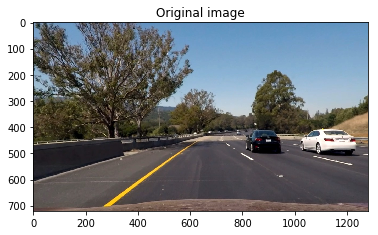

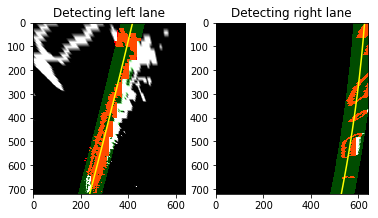

In [23]:
img_dist = mpimg.imread("test_images/test6.jpg")
img = undistort(img_dist)
img_shape = (img.shape[1], img.shape[0])

img_binary_filtered = filter(img)
img_binary_warped = warp(img_binary_filtered)

mid_point = img_binary_warped.shape[1]//2
img_left = img_binary_warped[:,:mid_point]
img_right = img_binary_warped[:,mid_point:]

ploty = np.linspace(0, img_shape[1]-1, img_shape[1])

line_left = Line().fit(img_left)
line_right = Line().fit(img_right)

leftx = line_left.pred(ploty)
rightx = line_right.pred(ploty)

plt.imshow(img)
plt.title("Original image")
plt.show()
    
fig = plt.figure()

img_left_lookup_margin = line_left._img_lookup_margin(img_left, ploty)
img_right_lookup_margin = line_right._img_lookup_margin(img_right, ploty)

fig.add_subplot(1, 2, 1)
plt.imshow(img_left_lookup_margin)
plt.plot(leftx, ploty, color='yellow')
plt.title("Detecting left lane")
plt.xlim(0, img_shape[0]//2)
plt.ylim(img_shape[1], 0)

fig.add_subplot(1, 2, 2)
plt.imshow(img_right_lookup_margin)
plt.plot(rightx, ploty, color='yellow')
plt.title("Detecting right lane")
plt.xlim(0, img_shape[0]//2)
plt.ylim(img_shape[1], 0)
plt.show()

In [24]:
ym_per_pix = 30./720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

def rad_curv(A, B, y):
    Am = A * xm_per_pix / (ym_per_pix**2)
    Bm = B * xm_per_pix / ym_per_pix
    ym = y * ym_per_pix
    return np.power(1 + np.square(2*Am*ym + Bm), 1.5) / np.abs(2*Am)

In [25]:
# https://stackoverflow.com/questions/16615662/how-to-write-text-on-a-image-in-windows-using-python-opencv2

font = cv2.FONT_HERSHEY_SIMPLEX
topCenterCorner = (80,80)
topCenterCorner_nxtline = (80,160)
fontScale = 1.5
fontColor = (255,255,255)
lineType = 2

def caption(img, rad, dist, dir):
    cv2.putText(img,'Radius of Curvature = %.0f(m)'% rad, 
                topCenterCorner, font, fontScale, fontColor, lineType)
    cv2.putText(img,'Vehicle is %.2fm %s of center' % (dist, dir), 
                topCenterCorner_nxtline, font, fontScale, fontColor, lineType)

In [26]:
line_left = Line()
line_right = Line()

ploty = np.linspace(img_shape[1]//2, img_shape[1]-1, img_shape[1]//2)

# i = 0
def process_image(img, debug=False):
    # global i
    # i += 1
    # plt.imsave("video_images/{0}.jpg".format(i), img)
    # return img

    img_undist = undistort(img)
    img_shape = (img_undist.shape[1], img_undist.shape[0])

    x_mid = img_shape[0]//2
    img_binary_filtered = filter(img_undist)
    # return np.dstack((img_binary_filtered, img_binary_filtered, img_binary_filtered))
    img_binary_warped = warp(img_binary_filtered)

    img_binary_warped_left = img_binary_warped[:,:x_mid]
    img_binary_warped_right = img_binary_warped[:,x_mid:]
    
    line_left.fit(img_binary_warped_left)
    line_right.fit(img_binary_warped_right)
    
    left_predx = line_left.pred(ploty)
    right_predx = line_right.pred(ploty)
    
    if debug:
        plt.imshow(img_binary_filtered, cmap='gray')
        plt.show()

        fig = plt.figure()

        fig.add_subplot(1, 2, 1)
        img_left_lookup_margin = line_left._img_lookup_margin(img_binary_warped_left, ploty)
        plt.imshow(img_left_lookup_margin)
        plt.plot(left_predx, ploty, color='yellow')
        plt.xlim(0, img_shape[0]//2)
        plt.ylim(img_shape[1], 0)

        fig.add_subplot(1, 2, 2)
        img_right_lookup_margin = line_right._img_lookup_margin(img_binary_warped_right, ploty)
        plt.imshow(img_right_lookup_margin)
        plt.plot(right_predx, ploty, color='yellow')
        plt.xlim(0, img_shape[0]//2)
        plt.ylim(img_shape[1], 0)
        plt.show()
    
    right_predx += x_mid
    
    # Add radius of curvature and distance from center
    left_rad = rad_curv(line_left._coeff[0], line_left._coeff[1], 720)
    right_rad = rad_curv(line_right._coeff[0], line_right._coeff[1], 720)
    rad = np.mean([left_rad, right_rad])
    
    lane_center = (left_predx[-1] + right_predx[-1]) // 2
    dir = "left" if lane_center < mid_point else "right"
    dist = np.abs(lane_center - mid_point) * xm_per_pix
    caption(img_undist, rad, dist, dir)
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(img_binary_warped).astype(np.uint8)
    img_color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_predx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_predx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    # cv2.fillPoly(img_color_warp, np.int_([pts]), (0, 255, 0))
    cv2.fillPoly(img_color_warp, np.int_([pts]), (0, 255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(img_color_warp, Minv, img_shape) 
    # Combine the result with the original image
    result = cv2.addWeighted(img_undist, 1, newwarp, 0.3, 0)
    
    return result

test_images/test6.jpg


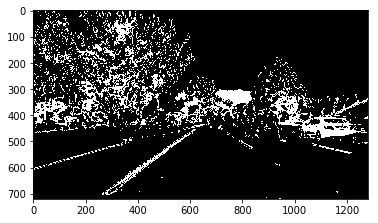

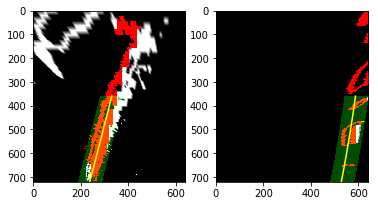

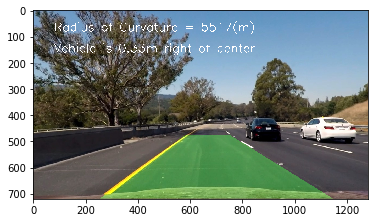

test_images/test5.jpg


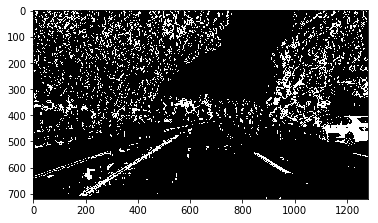

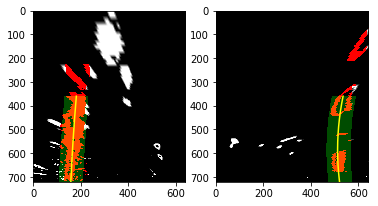

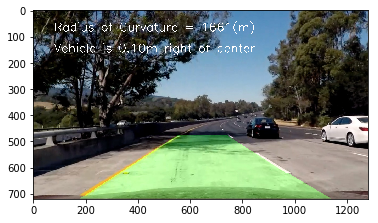

test_images/test4.jpg


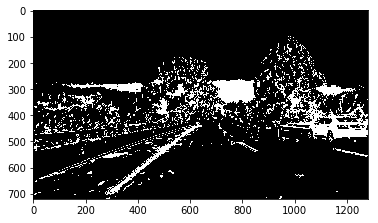

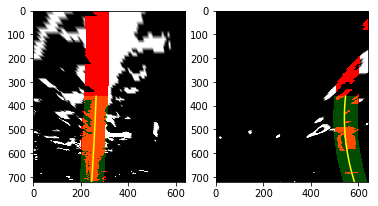

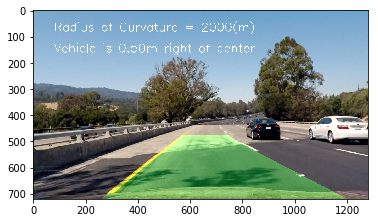

test_images/test1.jpg


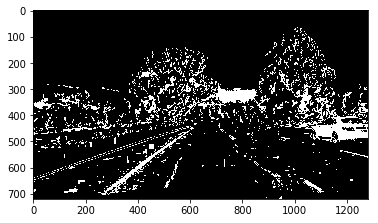

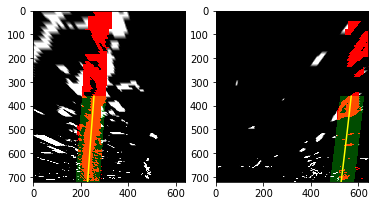

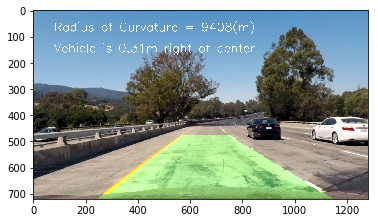

test_images/test3.jpg


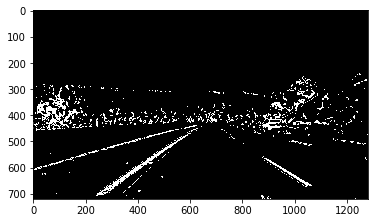

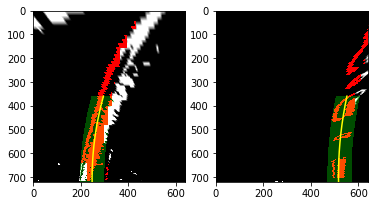

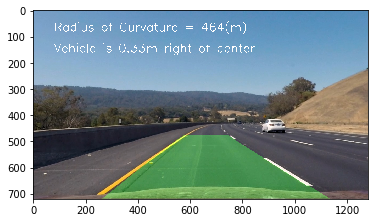

test_images/test2.jpg


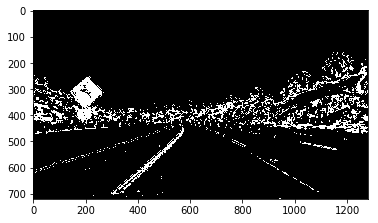

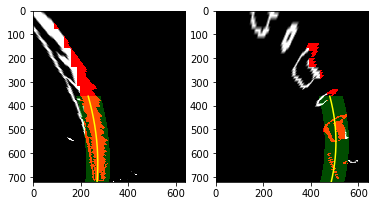

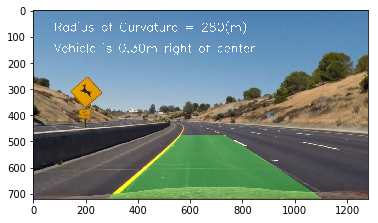

test_images/straight_lines2.jpg


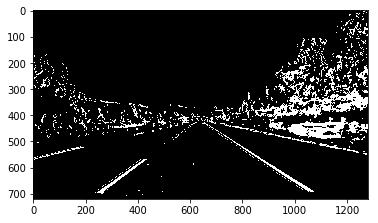

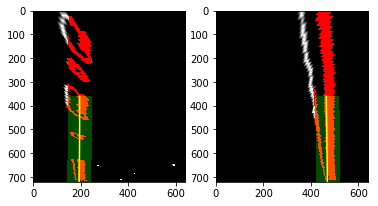

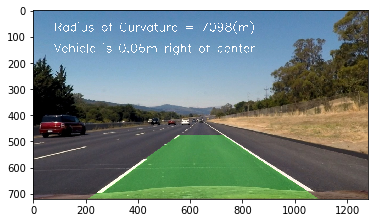

test_images/straight_lines1.jpg


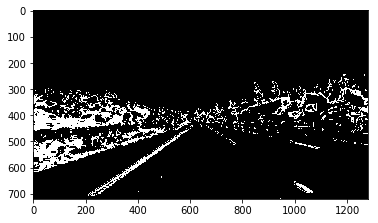

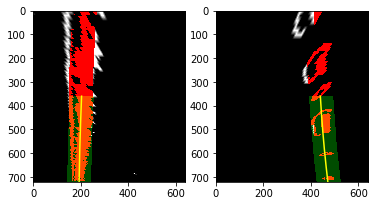

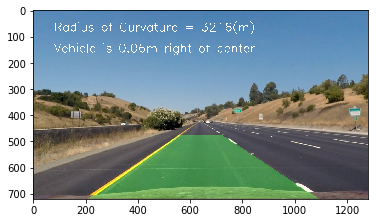

In [27]:
for img_path in glob.glob("test_images/*.jpg"):
    print(img_path)
    line_left = Line()
    line_right = Line()

    img = mpimg.imread(img_path)
    img_with_lane = process_image(img, debug=True)
    plt.imshow(img_with_lane)
    plt.show()

In [28]:
# Import everything needed to edit/save/watch video clips# Impor 
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [29]:
line_left = Line()
line_right = Line()

white_output = "./project_video_with_lanes.mp4"

clip1 = VideoFileClip('project_video.mp4')# Import everything needed to edit/save/watch video clips# Impor 
from moviepy.editor import VideoFileClip
from IPython.display import HTML
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video ./project_video_with_lanes.mp4
[MoviePy] Writing video ./project_video_with_lanes.mp4


100%|█████████▉| 1260/1261 [05:55<00:00,  3.55it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project_video_with_lanes.mp4 

CPU times: user 6min 41s, sys: 1min 4s, total: 7min 46s
Wall time: 5min 55s
